In [1]:
import datajoint as dj

dj.config["database.host"] = "datajoint-public.internationalbrainlab.org"
dj.config["database.user"] = "ibl-public"
dj.config["database.password"] = "ibl-public" 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses


[2022-07-23 00:43:47,738][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2022-07-23 00:43:50,004][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [3]:
# 'trial_reward_volume'
def fetch_mice_by_percentage(lab_mice, lab_mice_in_training, percentage):
  dictionary = {}

  for mouse in lab_mice:
    one_guy = lab_mice_in_training & {'subject_uuid' : mouse}
    total_trials = len(one_guy.fetch('training_status'))
    train_percentage = np.arange(1,total_trials+1) / total_trials
    train_percentage_bin = ((train_percentage // 0.1) + 1)*10
    where = np.where(train_percentage_bin == percentage)[0]
    if len(where) !=0:
      dictionary[mouse] = one_guy.fetch('session_start_time')[where]
  return dictionary

def search_sequence(arr,streak_length, feedback):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    streak_length    : input int

    Output
    ------    
    Output : 1D Array with 1s on indices where input array matches the sequence and 0s otherwise.
    """
    # Create the sequence to look for
    seq = np.ones(streak_length)*feedback

    # Store sizes of input array and sequence
    streak = np.zeros(arr.size)
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq)[:,None] + r_seq] == seq).all(1)

    # Get True values of M and write streak array
    where = np.where(M == True)[0] 
    streak[where] = 1

    return streak

def get_streak_data(lab,percentage):
  """ Returns streak of rewards and/or punishments before all trials with 50/50 probability, for all mice in chosen lab, with chosen training percentage.

  Parameters
  ----------    
  lab    : input string
  percentage    : input int

  Output
  ------    
  Output :
  2D array with size (features x samples)
  1D array with size samples
  """


  lab_mice_in_training = behavior_analyses.SessionTrainingStatus & 'training_status = "in_training" ' & (subject.SubjectLab & 'lab_name = "{}"'.format(lab)) 
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)

  X_0 = []   # contrast
  X_1 = []   # feature 1, streaks of 2
  X_2 = []   # feature 2, streaks of 3
  X_3 = []   # feature 3, punishment streaks of 2
  X_4 = []   # feature 4, punishment streaks of 3

  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
        x_0 = contrast_left + contrast_right
        x_1 = search_sequence(session,2,1) 
        x_2 = search_sequence(session,3,1)
        x_3 = search_sequence(session,2,-1) 
        x_4 = search_sequence(session,3,-1)  

        X_0 = np.append(X_0,x_0)
        X_1 = np.append(X_1,x_1)
        X_2 = np.append(X_2,x_2)
        X_3 = np.append(X_3,x_3)
        X_4 = np.append(X_4,x_4)

        y = np.append(y,session)
    except:
      pass

  X = np.vstack((X_0,X_1,X_2,X_3,X_4))
  X = X.astype("float")
  y = y.astype("float")

  return (X, y)

In [6]:
def streak_modelling(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X.T, y, test_size=0.25, random_state=0)
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train, y_train)
    coef = logisticRegr.coef_[0]

    y_pred = logisticRegr.predict(x_test)
    training_accuracy = logisticRegr.score(x_train, y_train)
    test_accuracy = logisticRegr.score(x_test, y_test)
    print("Training accuracy:{:.2f}  Test accuracy:{:.2f}".format(training_accuracy*100, test_accuracy*100))
    print("Precision:{:.2f} Recall:{:.2f}".format(precision_score(y_pred, y_test)*100,
                                                recall_score(y_pred, y_test)*100))
    # print("Coefficients for logistic regression:")
    # print(coef)
    # print(confusion_matrix(y_test,y_pred))
    return training_accuracy, test_accuracy

In [12]:
X, y = get_streak_data("mainenlab", 50)
streak_modelling(X,y)

[2022-07-23 00:38:26,965][WARNING]: MySQL server has gone away. Reconnecting to the server.


Training accuracy:0.8155760890062229  Test accuracy:0.8171404327535002

Precision:0.8435870698644421 Recall:0.8816477768090671

Coefficients for logistic regression:
[ 0.50394923  6.43689255  1.84567952 -5.77263494 -1.19024853]
[[1733  543]
 [ 750 4045]]


(0.8155760890062229, 0.8171404327535002)

In [7]:
pc=np.arange(10,100,10)
train=[]
test=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_streak_data("mainenlab", percentage)
    train_acc, test_acc = streak_modelling(data_X,data_y)
    train.append(train_acc)
    test.append(test_acc)
    print("-------------------------------------------------------------------\n")

[2022-07-23 00:49:52,453][WARNING]: MySQL server has gone away. Reconnecting to the server.


%_trained_mice_considered:10
Training accuracy:76.52  Test accuracy:75.75
Precision:72.82 Recall:74.70
-------------------------------------------------------------------

%_trained_mice_considered:20
Training accuracy:78.13  Test accuracy:77.02
Precision:76.13 Recall:75.39
-------------------------------------------------------------------

%_trained_mice_considered:30


<AxesSubplot:xlabel='%_trained'>

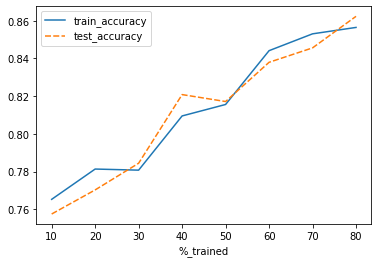

In [ ]:
data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                      "train_accuracy": train,
                                      "test_accuracy": test}
df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")
# df.head(10)
sns.lineplot(data=df)